<a href="https://colab.research.google.com/github/Hamza-333/Text-Summarizer/blob/main/413_Final_Project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 12.1 MB/s eta 0:00:00


In [3]:
from datasets import list_datasets, load_dataset

In [4]:
datasets = list_datasets()

In [9]:
# using around 76k train, 5k validation, 1.95k test
gigaword = load_dataset('gigaword', split = ['train[:2%]', 'validation[:3%]', 'test'])

Generating train split:   0%|          | 0/3803957 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/189651 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1951 [00:00<?, ? examples/s]

Dataset gigaword downloaded and prepared to /root/.cache/huggingface/datasets/gigaword/default/1.2.0/ea83a8b819190acac5f2dae011fad51dccf269a0604ec5dd24795b64efb424b6. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [14]:
# only using gigaword for now
train_data = gigaword[0]
val_data = gigaword[1]
test_data = gigaword[2]

In [16]:
train_data[0]

{'document': "australia 's current account deficit shrunk by a record #.## billion dollars -lrb- #.## billion us -rrb- in the june quarter due to soaring commodity prices , figures released monday showed .",
 'summary': 'australian current account deficit narrows sharply'}

# Data Preparation

In [17]:
import torch

In [18]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 96.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.5 MB/s eta 0:00:00


In [24]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [25]:
tokenizer.all_special_tokens

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]']

In [27]:
def preprocess_function(examples):
    """Create tokens for each example. Padding is done using the max length of
    example in the batch. Each example in the batch will have equal length"""

    # fixed size padding
    model_inputs = tokenizer(examples['document'], padding='max_length', \
                             max_length=75, add_special_tokens=True)

    labels = tokenizer(text_target=examples["summary"], padding='max_length', \
                       max_length=70, add_special_tokens=True)


    model_inputs["labels"] = labels["input_ids"]

    model_inputs["labels_mask"] = labels["attention_mask"]


    return model_inputs

In [28]:
import torch.nn as nn

In [29]:
from transformers import DataCollatorWithPadding

In [30]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [31]:
# Tokenize training data
train_data = train_data.map(preprocess_function, batched = True)

Map:   0%|          | 0/76079 [00:00<?, ? examples/s]

In [32]:
# Tokenize validation data
val_data = val_data.map(preprocess_function, batched = True)

Map:   0%|          | 0/5690 [00:00<?, ? examples/s]

In [33]:
# Tokenize test data
test_data = test_data.map(preprocess_function, batched = True)

Map:   0%|          | 0/1951 [00:00<?, ? examples/s]

In [34]:
# only keep the encoded columns
train_d = train_data.remove_columns(['document', 'summary'])

In [35]:
# format to pytorch
train_d = train_d.with_format("torch")

In [36]:
# only keep the encoded columns
val_d = val_data.remove_columns(['document', 'summary'])
test_d = test_data.remove_columns(['document', 'summary'])

In [37]:
# format to pytorch
val_d = val_d.with_format("torch")
test_d = test_d.with_format("torch")

In [38]:
# compute size of vocabulary
vocab_size = len(tokenizer.vocab)

In [39]:
# The dimension of the embeddings
EMB_DIM = 256

# Model

In [40]:
import math

In [41]:
class PositionalEncoding(nn.Module):
    def __init__(self):
        super(PositionalEncoding, self).__init__()

    def positional_encoding(self, dim_model, length):
        pos_encod = torch.zeros(length, dim_model)
        pos_list = torch.arange(0, length).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) #1000^(2i/dim_model)

        pos_encod[:, 0::2] = torch.sin(pos_list * div_term) # pe(even) = sin(pos/1000^(2i/dim_model))
        pos_encod[:, 1::2] = torch.cos(pos_list * div_term) # pe(odd) = cos(pos/1000^(2i/dim_model))
        if torch.cuda.is_available():
            pos_encod= pos_encod.cuda()
        return pos_encod
    
    def forward(self, embedding, dim_model, length):
        return embedding + self.positional_encoding(dim_model, length)


In [76]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=EMB_DIM, nhead=4, num_encoder_layers=2, \
                 num_decoder_layers=2, dim_feedforward=2048, dropout=0.15):
        super(TransformerModel, self).__init__()
        self.emb = nn.Embedding(vocab_size, d_model)
        self.pos = PositionalEncoding()
        # transformer model with encoder and decoders
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers,
                dim_feedforward, dropout, activation='relu', layer_norm_eps=1e-05, batch_first=True)

        # final fully connected linear layer for classification
        self.fc = nn.Linear(d_model, vocab_size)



    def forward(self, inp, tgt, src_pad_mask=None, tgt_pad_mask=None):

        # Positional encoding for input and target
        inp = self.emb(inp)
        tgt = self.emb(tgt)
 
        inp = self.pos(inp, EMB_DIM, inp.size(1))
        tgt = self.pos(tgt, EMB_DIM, tgt.size(1))
        # target mask for decoder
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1), device='cuda')
        # encoder and decoder of transformer
        out = self.transformer(inp, tgt, tgt_mask=tgt_mask, \
                               src_key_padding_mask=src_pad_mask, tgt_key_padding_mask=tgt_pad_mask)

        # final linear layer
        out = self.fc(out)

        return out

    

# Training and Validation

In [43]:
import torch.optim as optim

In [44]:
import random

In [45]:

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [46]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
from rouge import Rouge

In [51]:
def compute_rouge(outputs, targets):
    """Compute the total Rouge-1 f1 score for the generated outputs in the batch"""
    rouge = Rouge()
    scores = []
    total = 0
    for i in range(len(outputs)):

        out = torch.max(outputs[i], 0)[1]
        # convert into text
        score = rouge.get_scores(tokenizer.decode(out), tokenizer.decode(targets[i]))
        # accumalate f1 from rouge-l score
        total += score[0]['rouge-1']['f']

    # return total rouge score over the batch
    return total

In [52]:
def validation(model, val_data, batch_size):
    
    model.eval()
    # ignore padding tokens in loss computation
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    # load data with batch size of 64
    loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, \
                                         collate_fn=data_collator, shuffle=True)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"



    model.to(device)
    criterion.to(device)


    rouge_score = 0
    v_loss = 0
    for step, batch in enumerate(loader):
        # input token ids
        inp = batch['input_ids'].type(torch.long)
        # input target ids
        tgt_ind = batch['labels'].type(torch.long)
        # input padding mask
        inp_mask = batch['attention_mask']
        # target padding mask
        tgt_mask = batch['labels_mask']

        inp = inp.to(device)
        tgt_ind = tgt_ind.to(device)

        # padding mask so that model ignores padding tokens
        # matrix of booleans that tells model where padding tokens are
        # so that it can ignore
        inp_mask = (inp_mask > 0).type(torch.float32).to(device)
        tgt_mask = (tgt_mask > 0).type(torch.float32).to(device)

        # shift target output to the left, use this to compute loss 

        tgt_left_shifted = torch.zeros(tgt_ind.size())
        tgt_left_shifted[:, :-1] = tgt_ind[:, 1:].clone()
        tgt_left_shifted[:, -1] = tokenizer.pad_token_id
        tgt_left_shifted = tgt_left_shifted.type(torch.long).to(device)

        # shift target output to the right, use this as input 

        outputs = model(inp, tgt_ind, inp_mask, tgt_mask)

        outputs = torch.permute(outputs, (0,2,1))


        # compare output against the target indices 
        loss = criterion(outputs, tgt_left_shifted)

        # compute total loss
        v_loss += float(loss) * batch_size
        # compute rouge scores
        rouge_score += compute_rouge(outputs, tgt_ind)

    # return average loss and average rouge_score
    return v_loss / len(loader), rouge_score / len(loader)



        

In [74]:
train_losses = []
val_losses = []
iter_losses = []
iters = []
epochs = []
scores = []

In [70]:
def train(model, train_data, val_data, batch_size=64, weight_decay=0.0,
           learning_rate=0.0005, num_epochs=15, checkpoint_path=None):

    model.train()
    # ignore padding tokens in loss computation
    criterion = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
    # load data with batch size of 64
    loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, collate_fn=data_collator,\
                                         shuffle=True)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    epoch = 0

    n = 0


    model.to(device)
    criterion.to(device)
    lr = learning_rate

    while epoch < num_epochs:

        # Using AdamW for now, can try with other optimizers too
       
        optimizer = optim.AdamW(model.parameters(),
                lr=lr,
                weight_decay=weight_decay)
        
  
        t_loss = 0
        for step, batch in enumerate(loader):
            # input token ids
            inp = batch['input_ids'].type(torch.long)
            # input target ids
            tgt_ind = batch['labels'].type(torch.long)
            # input padding mask
            inp_mask = batch['attention_mask']
            # target padding mask
            tgt_mask = batch['labels_mask']

            if len(inp) < batch_size:
                # Last batch will have less images since it will be the
                # remainder of Total images / batch_size.

                # Adjust the learning rate of the last batch by 
                # (size(last_batch) / batch_size) to account 
                # for the smaller size.
                adj_lr = learning_rate * (len(inp) / batch_size)
                optimizer = optim.AdamW(model.parameters(),
                    lr=adj_lr,
                    weight_decay=weight_decay)


            inp = inp.to(device)
            tgt_ind = tgt_ind.to(device)
            # padding mask so that model ignores padding tokens
            # matrix of booleans that tells model where padding tokens are
            # so that it can ignore
            inp_mask = (inp_mask > 0).type(torch.float32).to(device)
            tgt_mask = (tgt_mask > 0).type(torch.float32).to(device)

            # shift target output to the left, use this to compute loss 

            tgt_left_shifted = torch.zeros(tgt_ind.size())
            tgt_left_shifted[:, :-1] = tgt_ind[:, 1:].clone()
            tgt_left_shifted[:, -1] = tokenizer.pad_token_id
            tgt_left_shifted = tgt_left_shifted.type(torch.long).to(device)

            
            outputs = model(inp, tgt_ind, inp_mask, tgt_mask)
            # reshape output
            outputs = torch.permute(outputs, (0,2,1))

            # compare output against the target indices 
            loss = criterion(outputs, tgt_left_shifted)

            loss.backward()

            optimizer.step()

            optimizer.zero_grad()
            # accumalate loss
            # Only summing the average batch loss would be inaccurate as 
            # last batch is smaller 

            # Multiply by batch size to get total loss 
            # will be used to compute average batch loss

            t_loss += float(loss) * batch_size
            iter_losses.append(float(loss))
            n += 1
            iters.append(n)

        # end of epoch


        epoch += 1

        train_losses.append(t_loss / len(loader))
        epochs.append(epoch)
        # get valdiation loss and rouge score
        val_loss, rouge_score = validation(model, val_data, batch_size)
        val_losses.append(val_loss)
        scores.append(rouge_score)
        # checkpoint model
        torch.save(model.state_dict(), checkpoint_path.format(epoch))
        print("Epoch {}:  [Train loss: {}]   [Validation loss: {}]   [Rouge score: {}]".format(epoch, t_loss / len(loader), val_loss, rouge_score))

    return epochs, train_losses, val_losses, iters, iter_losses

        

In [71]:
model = TransformerModel(vocab_size=vocab_size)

In [ ]:
epochs, train_losses, val_losses, iters, iter_losses = train(model, train_d, val_d, checkpoint_path='/content/gdrive/My Drive/CSC413/Project/Transformer-Rouge-4-6-6-ckpt1-{}.pk')

In [62]:
import matplotlib.pyplot as plt

In [63]:
def plot_learning_curve(iters, iter_losses, epochs, train_losses, val_losses, rouge):
    """
    Plot the learning curve.
    """
    plt.title("Learning Curve: Loss per Iteration")
    plt.plot(iters, iter_losses)
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve: Loss per Epoch")
    plt.plot(epochs, train_losses, label="Train")
    plt.plot(epochs, val_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Validation Rouge Scores per Epoch")
    plt.plot(epochs, rouge)
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.show()


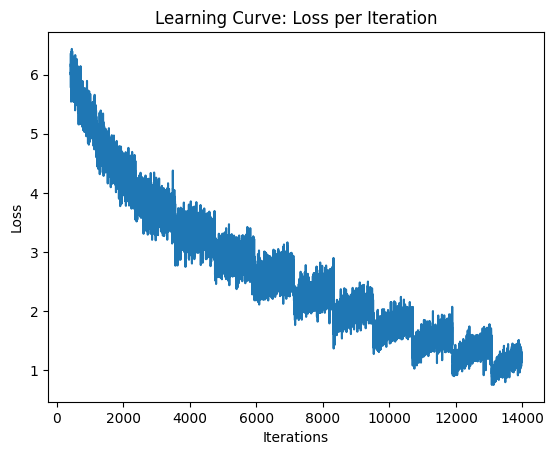

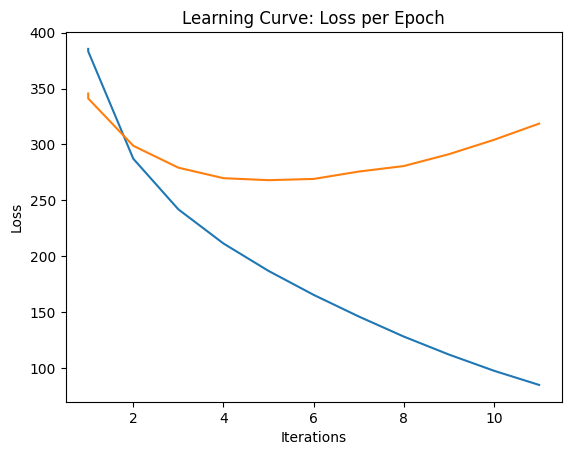

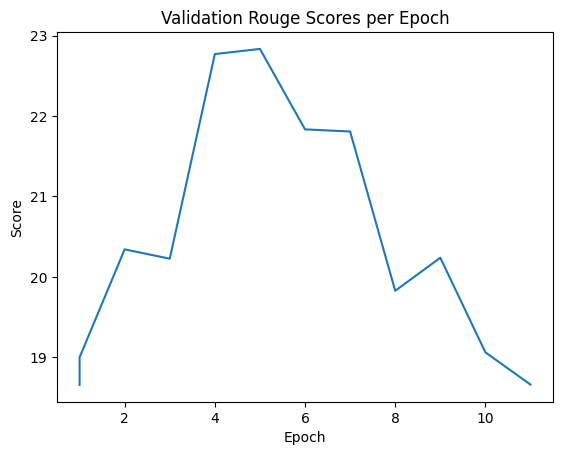

In [95]:
# Training curve for final model: 4 heads 2 encoders/decoders and lr=0.00025
plot_learning_curve(iters, iter_losses, epochs, train_losses, val_losses, scores)

In [77]:
# load trained model
model = TransformerModel(vocab_size=vocab_size)
model.load_state_dict(torch.load\
                      ('/content/gdrive/My Drive/CSC413/Project/Transformer-Rouge-4-2-2-ckpt-5.pk'))

<All keys matched successfully>

In [114]:
def test(model, input, tgt_orig):

    model.eval()

    # define initial source sequence (e.g., a prompt)

    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    rouge = Rouge()
    # Initial target sequence will just be [CLS] token
    # reshape all tensors 
    target = torch.tensor(tokenizer.cls_token_id, dtype=torch.long).to(device)
    target = torch.reshape(target, (1,1 ))
    input = torch.reshape(input, (1, input.size(0))).to(device)


    # maximum length of sequence is 69 + CLS = 70 same as target length
    max_length = 69

    output = []
    for _ in range(max_length):
        with torch.no_grad():
            # predict next token based on previous token
            out = model(input, target)
            # only take the last generated token
            next_token = out.topk(1)[1].view(-1)[-1].item() # num with highest probability
            next_token = torch.tensor([[next_token]], device=device)
            # Generated sequence ends once [SEP] token is generated 
            if next_token == tokenizer.sep_token_id:
                break
            # append predicted token to previous tokens, use them to predict next token
            target = torch.cat([target, next_token], dim=1)

        
    # convert output tokens to text
    # Find index of [SEP] token in the target summary
    ind = list(tgt_orig).index(tokenizer.sep_token_id)
    # compare output against the target without the [SEP] or [PAD] tokens
    tgt = list(tgt_orig)[:ind]
    score = rouge.get_scores(tokenizer.decode(target[0]), tokenizer.decode(tgt))
    generated = tokenizer.decode(target[0])\
    # print each test examples
    print('-------------------------------------------------------------------')
    print("Input: ", tokenizer.decode(input[0]))
    print("Target: ", tokenizer.decode(tgt_orig))
    print("Text generated: ", generated)
    print("Rouge Score: ", score[0]['rouge-1']['f'])
    return score[0]['rouge-1']['f'], generated


In [116]:
def evaluate(model, t_data):
    model.eval()
    # batch size is one since we will genreating text for each example one by one
    loader = torch.utils.data.DataLoader(t_data, batch_size=1, collate_fn=data_collator)
    device = "cuda:0" if torch.cuda.is_available() else "cpu"

    
    model.to(device)

    # rouge_scores = []
    total = 0
    # keep track of the best score
    max_score = -1
    # keep track of the worst score
    min_score = 100
    # keep track of the best and worst generated examples
    examples = [None, None]
    # count number of 'good' generations
    good_count = 0
    # count number of 'okay' generations
    mid_count = 0
    for step, batch in enumerate(loader):
        # input token ids
        inp = batch['input_ids'].type(torch.long)
        # input target ids
        tgt_ind = batch['labels'].type(torch.long)
        score, generated  = test(model, inp[0], tgt_ind[0])
        if score > max_score:
            max_score = score
            # store new best example
            examples[0] = (score, tokenizer.decode(inp[0]), tokenizer.decode(tgt_ind[0]),\
                                   generated)
        elif score < min_score:
            min_score = score
            # store new worst example
            examples[1] = (score, tokenizer.decode(inp[0]), tokenizer.decode(tgt_ind[0]),\
                                    generated)
        if score >= 0.5:
            good_count += 1
        elif 0.5 > score >= 0.35:
            mid_count += 1
        total += score
        # rouge_scores.append(score)
    # return average rouge score, examples, percent of good examples, percent of okay examples
    return total/len(loader), examples, good_count / len(loader), mid_count / len(loader)


# Test Performance

In [ ]:
# prints out all test examples
avg_test_rouge, examples, percent_good, percent_mid = evaluate(model, test_d)

In [118]:
# average rouge score for the test data
avg_test_rouge

0.2913108834606852

In [ ]:
# the best and worst generated examples 
examples

In [113]:
# percentage of good generations (rouge score >= 0.5)
percent_good

0.10097385955920041

In [119]:
# percentage of okay generations (0.35 <= rouge score < 0.5)
percent_mid

0.2070732957457714